## **Store Sales Forecasting - Kaggle Competition**



Retail businesses rely on accurate sales forecasting to optimize inventory, plan promotions, and maximize revenue.
In this competition, we aim to build a highly accurate time series forecasting model to predict store sales.

### **Problem Statement**
The goal is to predict daily sales for multiple stores based on historical data.
By understanding sales trends and seasonal effects, businesses can make data-driven decisions to boost revenue and reduce stock shortages.

### **Objectives**
Explore historical sales data to uncover patterns and trends
Identify key factors affecting sales (holidays, promotions, store types, etc.)
Develop a powerful predictive model using machine learning
Generate insights that businesses can use to optimize strategy
Kaggle competition and showcase our analytical skills!

# **Import necessary libraries for data manipulation, modeling, and evaluation**

In [ ]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing, SimpleExpSmoothing
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
import plotly.express as px
import pandas as pd
from xgboost import XGBRegressor
import numpy as np
import plotly.graph_objects as go
import pandas as pd
import warnings
from itertools import product
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# **Load datasets**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/train.csv', parse_dates=['date'])
df_oil = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/oil.csv', parse_dates=['date'])
df_sample_submission = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/sample_submission.csv')
df_stores = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/stores.csv')
df_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/test.csv', parse_dates=['date'])
df_transaction = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/transactions.csv', parse_dates=['date'])
df_holidays_events = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/holidays_events.csv', parse_dates=['date'])

In [ ]:
df_train  =  pd.read_csv('train.csv', parse_dates=['date'])
df_oil = pd.read_csv('oil.csv', parse_dates=['date'])
df_sample_submission = pd.read_csv('sample_submission.csv')
df_stores = pd.read_csv('stores.csv')
df_test = pd.read_csv('test.csv', parse_dates=['date'])
df_transaction = pd.read_csv('transactions.csv', parse_dates=['date'])
df_holidays_events = pd.read_csv('holidays_events.csv', parse_dates=['date'])

# **displays the shapes (number of rows and columns) of the loaded datasets**

In [ ]:
print(df_train.shape)
print(df_oil.shape)
print(df_sample_submission.shape)
print(df_stores.shape)
print(df_test.shape)
print(df_transaction.shape)
print(df_holidays_events.shape)

(3000888, 6)
(1218, 2)
(28512, 2)
(54, 5)
(28512, 5)
(83488, 3)
(350, 6)


# **Create copies of train and test data**

In [ ]:
train = df_train.copy()
test = df_test.copy()

## **Define MASE (Mean Absolute Scaled Error) function**

In [ ]:
def mase(y_true, y_pred, y_train) -> float:
    naive_forecast = y_train[:-1]  # naive forecast: previous value
    mae_naive = mean_absolute_error(y_train[1:], naive_forecast)
    mase = mean_absolute_error(y_true, y_pred) / mae_naive
    return mase

# **Define model evaluation function**

In [ ]:
def eval_model(y_true, y_pred) :
    # Calculate the mean squared logarithm error
    print(f"mean squared logarithm error: {np.sqrt(mean_squared_log_error(y_true, y_pred))}")
    print(f"R Sccore model score: {r2_score(y_true, y_pred)}")
    print(f"mean absolute error: {mean_absolute_error(y_true, y_pred)}")
    print(f"mean squared error: {mean_squared_error(y_true, y_pred)}")
    print(f"mase: {mase(y_true, y_pred, y_true)}")

# **Define plotting function**

visualize predicted sales vs real sales

In [ ]:
def plot_func(pred_data, t_data, c: int, f: str, title : str) -> None:
    data_c_f = t_data[(t_data['store_nb'] == c) & (t_data['family'] == f)]
    forecasts = pred_data[(pred_data['store_nb'] == c) & (pred_data['family'] == f)]
    #train_split = data_c_f[:-int(len(data_c_f)*0.2)]
    #train_split = train_split[train_split['date'].isin(df_holidays_events['date'])]
    #forecasts = forecasts[forecasts['date'].isin(df_holidays_events['date'])]
    fig = go.Figure()
    fig.add_trace(go.Scatter(x=data_c_f['date'], y=data_c_f['sales'], name='Train'))
    #fig.add_trace(go.Scatter(x=forecasts['date'], y=forecasts['sales'], name='Test'))
    fig.add_trace(go.Scatter(x=forecasts['date'], y=forecasts['sales'], name='Forecast'))
    fig.update_layout(template='simple_white', font=dict(size=10), title_text=title, xaxis_title='date',yaxis_title='Sales', width=750)

    #eval_model(forecasts['sales'], forecasts['sales_forecast'])

    return fig.show()

# **Simple Exponentielle Smoothinh**

In [ ]:
def forecast_SES(args) -> pd.DataFrame:

    train_cluster_family , test_cluster_family, holiday_df = args

    model = SimpleExpSmoothing(train_cluster_family['sales']).fit(optimized=True)

    predictions = model.forecast(len(test_cluster_family))

    predictions = pd.DataFrame({'date': test_cluster_family['date'], 'sales': predictions})

    predictions = pd.merge(predictions, test_cluster_family, on='date', how='left')

    return predictions

# **Preprocing Holiday dataset for Prophet**

In [ ]:
holiday_df = df_holidays_events[['date', 'type']].drop_duplicates()
holiday_df.rename(columns={'date':'ds', 'type':'holiday'}, inplace=True)
holiday_df['lower_window'] = 0
holiday_df['upper_window'] = 1
holiday_df.head()

,ds,holiday,lower_window,upper_window
0,2012-03-02,Holiday,0,1
1,2012-04-01,Holiday,0,1
2,2012-04-12,Holiday,0,1
3,2012-04-14,Holiday,0,1
4,2012-04-21,Holiday,0,1


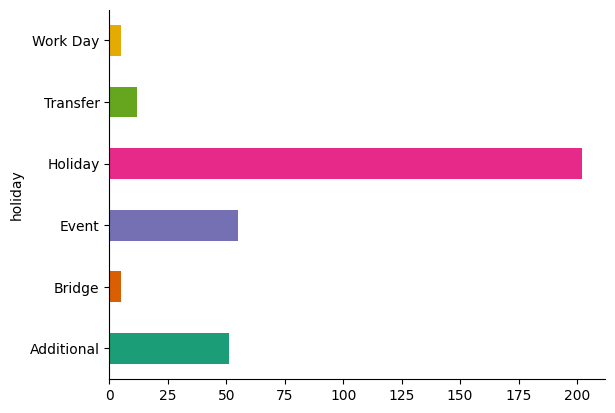

In [ ]:
# @title holiday

from matplotlib import pyplot as plt
import seaborn as sns
holiday_df.groupby('holiday').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [ ]:
train.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


# **Prophet**

   Explains how Prophet optimizes its model.

    Prophet optimizes its additive model:
    y(t) = g(t) + s(t) + h(t) + ϵ(t)

    where:
    g(t) = trend (logistic or linear growth)
    s(t) = seasonality (yearly, weekly, daily if enabled)
    h(t) = holiday effects
    ϵ(t) = random error

    Optimization process:

    1. Internal Hyperparameter Tuning:
       - Automatically adjusts changepoints and their impacts using regularization.
       - Tunes the coefficients of seasonal components.

    2. Bayesian Estimation (Optional):
       - If `mcmc_samples > 0`, uses Bayesian estimation (MCMC) to improve uncertainty quantification.

    3. Loss Function Minimization:
       - Optimizes parameters using gradient descent by minimizing a loss function based on the error between predictions and actual data.

    User-Defined Hyperparameters:
    Prophet does *not* automatically optimize user-defined hyperparameters, including:
       - changepoint_prior_scale (trend regularization)
       - seasonality_prior_scale (seasonality regularization)
       - interval_width (confidence interval)
       - holidays_prior_scale (holiday impact)


| **Method** | **Advantages** | **Limitations** |
|------------|--------------|----------------|
| **`growth='logistic'` with `cap`** | Prevents extreme values from exceeding a maximum limit | Not suitable for all time series |
| **Reduce `changepoint_prior_scale`** | Avoids Prophet detecting too many trend changes | May underfit the predictions |
| **Subtract the mean before training** | Simple and effective | Doesn't work well if the trend is strong |
| **Use `floor` to prevent negative values** | Ensures Prophet doesn’t predict unrealistic values | Must be carefully calibrated |
| **Apply `np.maximum` and `np.minimum` after prediction** | Easy to implement | Not a true correction of the model |

 **If Prophet is overestimating growth, start with `growth='logistic'` and `changepoint_prior_scale=0.01`**.  
If that’s not enough, combine multiple methods to constrain predictions.


In [ ]:
from prophet import Prophet
from multiprocessing import Pool, cpu_count
import os

def train_predict_prophet(args):
    train_data, test_data, holiday_df= args


    #Q_1 = train_data['sales'].quantile(0.25)
    # Q_3 = train_data['sales'].quantile(0.75)
    #IQR = Q_3 - Q_1
    #lower_bound = Q_1 - 1.5 * IQR
    # upper_bound = Q_3 + 1.5 * IQR
    #train_data = train_data[(train_data['sales'] >= lower_bound) & (train_data['sales'] <= upper_bound)]

    # Prophet requires 'ds' and 'y' columns
    train_data = train_data.rename(columns={'date': 'ds', 'sales': 'y'})
    train_data = train_data[['ds','y','onpromotion']]

    train_data['onpromotion'] = train_data['onpromotion'].fillna(0)

    cap_value = train_data['y'].max() * 1.2
    train_data['cap'] = max(cap_value, 1)

    train_data['is_weekend'] = (train_data['ds'].dt.weekday >= 5).astype(int)


    model = Prophet(
        interval_width=0.85,
        holidays=holiday_df,
        uncertainty_samples=100,
        growth='logistic',
        changepoint_prior_scale=0.1,
        seasonality_prior_scale=0.1,
        n_changepoints=15,
        weekly_seasonality=False,
        daily_seasonality=False
    )

    # model.add_regressor('is_weekend')
    model.add_regressor('onpromotion')

    # Initialize and fit the Prophet model
    # model = Prophet(interval_width=0.85, holidays=holiday_df, changepoint_prior_scale=0.03)

    model.fit(train_data)

    # Create future dataframe for predictions
    future = model.make_future_dataframe(periods=len(test_data))


    future['is_weekend'] = (future['ds'].dt.weekday >= 5).astype(int)
    test_data.rename(columns={'date': 'ds'}, inplace=True)
    future['onpromotion'] = future.merge(test_data[['ds', 'onpromotion']], on='ds', how='left')['onpromotion'].fillna(0)

    # Add 'cap' and 'floor' columns to the future dataframe
    future['cap'] = train_data['cap'].iloc[0] # Use the same capacity as the training data

    # Make predictions
    forecast = model.predict(future)

    # Save the plot as an image file
    # Create the directory if it doesn't exist
    #directory = f'cluster_{cluster}_family_{family}'  # Directory name
    #os.makedirs(directory, exist_ok=True)  # Create if not exists

    # Save the plot as an image file to the created directory
    #fig = model.plot(forecast)
    #plt.title(f'Cluster {cluster} - Family {family}')
    #file_path = os.path.join(directory, f'cluster_{cluster}_family_{family}.png')  # Save plot to file
    #fig.savefig(file_path)
    #plt.close(fig)  # Close the figure to release resources

    # Extract predictions for the test period
    predictions = forecast[['ds', 'yhat']][-len(test_data):].rename(columns={'ds': 'date', 'yhat': 'sales'})
    test_data.rename(columns={'ds': 'date'}, inplace=True)
    predictions = pd.merge(predictions, test_data, on='date', how='left')

    return predictions

# **Generating Groups of store , family product and sales**

In [ ]:
def create_group(args) -> pd.DataFrame:
    c, f , date , y = args

    group = []
    for store in train.store_nbr.unique():
        for family in train.family.unique():
            train_store_family = train[(train[c] == store) & (train[f] == family)].reset_index(drop=True)
            test_store_family = test[(test[c] == store) & (test[f] == family)].reset_index(drop=True)
            range_date = pd.date_range(start=train_store_family[date].min(), end=train_store_family[date].max(), freq='D')

            train_store_family[date] = pd.to_datetime(train_store_family[date])

            train_cluster_family  = pd.merge(pd.DataFrame({date: range_date}), train_store_family, on=[date], how='left')
            train_cluster_family[y].fillna(0, inplace=True)

            group.append((train_cluster_family,test_store_family,holiday_df))

    return group


In [ ]:
group = create_group(('store_nbr', 'family' , 'date' , 'sales'))

# **Run Prophet within Multiprocessing**

In [ ]:
if __name__ == '__main__':
    #group = create_group(('store_nbr', 'family' , 'date' , 'sales'))

    with Pool(processes=cpu_count()) as pool:
        results = pool.map(train_predict_prophet, group)

    # Combine the results
    final_predictions = pd.concat(results)

    # Ensure predictions are not negative
    final_predictions['sales'] = np.maximum(0, final_predictions['sales'])

    df_sample_submission.drop(columns=['sales'], inplace=True)

    df_sample_submission = df_sample_submission.merge(final_predictions[['id', 'sales']], on='id', how='left')

    df_sample_submission.to_csv('sample_submission_3.csv', index=False)

Streaming output truncated to the last 5000 lines.
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=85388', 'data', 'file=/tmp/tmpfxd020tw/o3wu_5v9.json', 'init=/tmp/tmpfxd020tw/dg119dkr.json', 'output', 'file=/tmp/tmpfxd020tw/prophet_modelw4val78q/prophet_model-20250204221718.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:17:18 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmprjyszxd_/74odkb0p.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=75407', 'data', 'file=/tmp/tmprjyszxd_/o22wnxpk.json', 'init=/tmp/tmprjyszxd_/74odkb0p.json', 'output', 'file=/tmp/tmprjyszxd_/prophet_model9dtkp403/prophet_model-2025020422

In [ ]:
df_sample_submission.sales.fillna(0, inplace=True)
df_sample_submission.to_csv('sample_submission_3.csv', index=False)

# **Compare current forecasting with previous forecasting**
Taking previous best evaluated forecat as observed value , and evaluate how far the current predicted sales for the previous forecast

In [ ]:
def compare_forecasting(path_current, path_old):
    current_forecasting  = pd.read_csv(path_current)
    old_forecasting = pd.read_csv(path_old)
    eval_model(current_forecasting['sales'], old_forecasting['sales'])

In [ ]:
compare_forecasting('sample_submission_1.csv' , 'sample_submission_3.csv')

mean squared logarithm error: 0.02418711009619045
R Sccore model score: 0.9998361992533333
mean absolute error: 2.368616659566926
mean squared error: 285.898385046781
mase: 0.002869671259972983


# **visualize sales volume based on the store and family product**

In [ ]:
def plot_sales_volumes(df: pd.DataFrame, target, feature_1, feature_2, feature_1_v, feature_2_v ) -> None:

    df_filtered = df[(df[feature_1] == feature_1)&(df[feature_2] == feature_2)]
    df_filtered = df_filtered.groupby([target])[target].sum().reset_index()

    fig = px.line(df_filtered, x=target, y=y)
    fig.update_layout(template="simple_white", font=dict(size=12),
                      title_text=f'Sales for family product {feature_2_v} in store {feature_1_v}',
                      width=850, title_x=0.5)
    return fig.show()

df['month'] = df['date'].dt.to_period('M')
plot_sales_volumes(df=train, target='month', feature_1='store_nbr', feature_1_v=1, feature_2='family', feature_2_v ='BEAUTY')

# **ENSEMBLE LEARNING:  RANDOMFOREST , xgboost , xgblight**

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

# **Creating a Consolidated Dataset with Holiday Features**

In [ ]:
df = pd.concat([df_train, df_test])
# Merge train data with oil prices
df = pd.merge(df, df_oil, on='date', how='left')
df['dcoilwtico'] = df['dcoilwtico'].fillna(0)
# Merge with store information
df = pd.merge(df, df_stores, on='store_nbr', how='left')
df = pd.merge(df, df_transaction, on=['date', 'store_nbr'], how='left')
df.transactions = df.transactions.fillna(0)
# Merge with holidays and events
for holiday in df_holidays_events['type'].unique():
     df[f'{holiday}'] = (df['date'].isin(df_holidays_events[df_holidays_events['type'] == holiday]['date'])).astype(int)

In [ ]:


from sklearn.preprocessing import MinMaxScaler, StandardScaler

def scale_data(df, columns_to_scale, scaler_type='minmax'):
  """
  Scales the specified columns of a DataFrame using either MinMaxScaler or StandardScaler.

  Args:
      df (pd.DataFrame): The DataFrame containing the data to be scaled.
      columns_to_scale (list): A list of column names to be scaled.
      scaler_type (str): The type of scaler to use ('minmax' or 'standard'). Defaults to 'minmax'.

  Returns:
      pd.DataFrame: A new DataFrame with the specified columns scaled.
      scaler : The trained scaler
  Raises:
      ValueError: If an invalid scaler_type is provided.
  """
  df_scaled = df.copy()
  if scaler_type == 'minmax':
    scaler = MinMaxScaler()
  elif scaler_type == 'standard':
    scaler = StandardScaler()
  else:
    raise ValueError("Invalid scaler_type. Choose 'minmax' or 'standard'.")

  df_scaled[columns_to_scale] = scaler.fit_transform(df[columns_to_scale])
  return df_scaled

columns_to_scale = ['dcoilwtico', 'transactions', 'onpromotion']

#scale with minmax
df_scaled= scale_data(df, columns_to_scale, scaler_type='minmax')

print("Dataframe scaled:")
df_scaled.query('onpromotion  >0').head()


Dataframe scaled:


,id,date,store_nbr,family,sales,onpromotion,dcoilwtico,city,state,type,cluster,transactions,Holiday,Transfer,Additional,Bridge,Work Day,Event
810784,810784,2014-04-01,9,CLEANING,1752.00000,0.004049,0.901193,Quito,Pichincha,B,6,0.288073,1,0,0,0,0,0
810789,810789,2014-04-01,9,GROCERY I,7685.00000,0.006748,0.901193,Quito,Pichincha,B,6,0.288073,1,0,0,0,0,0
812571,812571,2014-04-02,9,GROCERY I,6481.00000,0.004049,0.900380,Quito,Pichincha,B,6,0.253499,0,0,0,0,0,0
812587,812587,2014-04-02,9,POULTRY,613.71704,0.001350,0.900380,Quito,Pichincha,B,6,0.253499,0,0,0,0,0,0
814346,814346,2014-04-03,9,BREAD/BAKERY,521.00000,0.001350,0.906617,Quito,Pichincha,B,6,0.272401,0,0,0,0,0,0


## **DROP unecessary columns like id, city and state**

In [ ]:
df_scaled.drop(columns=['id', 'store_nbr', 'family', 'city', 'state', 'cluster'], inplace=True)


# **Converting Categorical Data to Numerical using One-Hot Encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder

# Identify categorical columns
categorical_cols = df_scaled.select_dtypes(include=['object']).columns

# Apply label encoding to each categorical column
for col in categorical_cols:
  le = LabelEncoder()
  df_scaled[col] = le.fit_transform(df_scaled[col])

df_scaled

,date,store_nbr,family,sales,onpromotion,dcoilwtico,type,transactions,Holiday,Transfer,Additional,Bridge,Work Day,Event
0,2013-01-01,1,0,0.0,0.000000,0.000000,3,0.0,1,0,0,0,0,0
1,2013-01-01,1,1,0.0,0.000000,0.000000,3,0.0,1,0,0,0,0,0
2,2013-01-01,1,2,0.0,0.000000,0.000000,3,0.0,1,0,0,0,0,0
3,2013-01-01,1,3,0.0,0.000000,0.000000,3,0.0,1,0,0,0,0,0
4,2013-01-01,1,4,0.0,0.000000,0.000000,3,0.0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3029395,2017-08-31,9,28,NaN,0.001350,0.427228,1,0.0,0,0,0,0,0,0
3029396,2017-08-31,9,29,NaN,0.000000,0.427228,1,0.0,0,0,0,0,0,0
3029397,2017-08-31,9,30,NaN,0.001350,0.427228,1,0.0,0,0,0,0,0,0
3029398,2017-08-31,9,31,NaN,0.012146,0.427228,1,0.0,0,0,0,0,0,0


In [ ]:
label_encoder = OneHotEncoder(sparse_output=False , handle_unknown='ignore')
categorical_features = df_scaled.select_dtypes(include=['object']).columns
numerical_features = df_scaled.select_dtypes(include=['number','datetime']).columns
#for feature in label_features:
encoded_features= label_encoder.fit_transform(df_scaled[categorical_features])
encoded_df = pd.DataFrame(encoded_features, columns=label_encoder.get_feature_names_out(categorical_features))
# Concatenate numerical and encoded features:
df_encoded = pd.concat([df_scaled[numerical_features], encoded_df], axis=1)
df_encoded.head()

,date,store_nbr,sales,onpromotion,dcoilwtico,transactions,Holiday,Transfer,Additional,Bridge,...,family_POULTRY,family_PREPARED FOODS,family_PRODUCE,family_SCHOOL AND OFFICE SUPPLIES,family_SEAFOOD,type_A,type_B,type_C,type_D,type_E
0,2013-01-01,1,0.0,0.0,0.0,0.0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2013-01-01,1,0.0,0.0,0.0,0.0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2013-01-01,1,0.0,0.0,0.0,0.0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,2013-01-01,1,0.0,0.0,0.0,0.0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,2013-01-01,1,0.0,0.0,0.0,0.0,1,0,0,0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


## **Splitting Data into Training and Testing Sets**


In [ ]:
data_train = df_encoded[:-len(df_test)]
data_test =  df_encoded[-len(df_test):]

In [ ]:
print(data_train.shape)
print(data_test.shape)

(3000888, 50)
(28512, 50)


## **Splitting Data into Training and validation Sets**

In [ ]:
X = data_train.drop(['date', 'sales'], axis=1)
y = data_train['sales']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

## **Build and fit RandomforestRegressor**

In [ ]:
rf =  RandomForestRegressor(n_estimators=50, min_samples_split=10,min_samples_leaf=5, n_jobs=-1, random_state=42)
rf.fit(X_train, y_train)
print("model has been fitted with train data")

model has been fitted with train data


### **evaluate the model over mulitple metrics**

In [ ]:
#evaluate trained model
y_pred_rf = rf.predict(X_val)
# Ensure predictions are non-negative
y_pred_rf = np.maximum(0, y_pred_rf)
eval_model(y_val, y_pred_rf)

mean squared logarithm error: 0.6074172147553152
R Sccore model score: 0.9412467625100915
mean absolute error: 79.44925452627828
mean squared error: 108896.81577454688
mase: 0.09777212510873806


## **Build and fit XGBOOST**

In [ ]:
# Custom objective function for RMSLE
def rmsle_obj(y_true, y_pred):
    # Ensure the prediction is always positive (log(1 + y) is undefined for negative values)
    y_true = np.maximum(0, y_true)
    y_pred = np.maximum(0, y_pred)

    grad = np.log(1 + y_pred) - np.log(1 + y_true)  # First derivative
    hess = 1 / (1 + y_pred + 1e-10)  # Second derivative (approximation)

    return grad, hess

# Custom evaluation metric for RMSLE
def rmsle_metric(y_true, y_pred):
    y_true = np.maximum(0, y_true)
    y_pred = np.maximum(0, y_pred)
    # Compute RMSLE
    rmsle = np.sqrt(np.mean((np.log1p(y_pred) - np.log1p(y_true)) ** 2))
    return rmsle


In [ ]:
from itertools import product

# Définir la grille des hyperparamètres
param_grid = {
    'n_estimators': [300],
    'max_depth': [7, None],
    'learning_rate': [0.1],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}

# Générer toutes les combinaisons possibles de paramètres
param_combinations = list(product(*param_grid.values()))

best_score = float("inf")  # Meilleur score initialisé à l'infini
best_params = None  # Meilleurs paramètres

# Boucle sur toutes les combinaisons
for params in param_combinations:
    # Extraire les paramètres
    param_dict = dict(zip(param_grid.keys(), params))

    # Initialiser le modèle avec les paramètres courants
    model = XGBRegressor(
        **param_dict,
        random_state=42
    )

    # Entraîner le modèle sur les données d'entraînement
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)

    # Faire des prédictions
    y_pred = model.predict(X_val)

    # Calculer le RMSLE (Root Mean Squared Logarithmic Error)
    score = rmsle_metric(y_val, y_pred)

    #print(f"Testé : {param_dict} -> RMSLE: {score:.5f}")

    # Mettre à jour les meilleurs paramètres si un meilleur score est trouvé
    if score < best_score:
        best_score = score
        best_params = param_dict

# Afficher les meilleurs paramètres trouvés
print("\n✅ Meilleurs paramètres:", best_params)
print("🏆 Meilleur score RMSLE:", best_score)


✅ Meilleurs paramètres: {'n_estimators': 300, 'max_depth': 7, 'learning_rate': 0.1, 'subsample': 1, 'colsample_bytree': 0.8}
🏆 Meilleur score RMSLE: 1.120650542733363


In [ ]:
X_test = data_test.drop(['date','sales'],axis=1)
y_test= rf.predict(X_test)
Y_test = np.maximum(0, y_test)
df_test['sales'] = y_test
df_test['date'] =  data_test['date'].values
df_test.head()

,id,date,store_nbr,family,onpromotion,sales
0,3000888,2017-08-16,1,AUTOMOTIVE,0,6.797750
1,3000889,2017-08-16,1,BABY CARE,0,0.000000
2,3000890,2017-08-16,1,BEAUTY,2,10.185481
3,3000891,2017-08-16,1,BEVERAGES,20,4775.246174
4,3000892,2017-08-16,1,BOOKS,0,0.000000


In [ ]:
df_sample_submission.drop(columns=['sales'], inplace=True)
df_sample_submission['sales'] = y_test
df_sample_submission.to_csv('sample_submission3.csv', index=False)

In [ ]:
df_sample_submission

,id,sales
0,3000888,6.797750
1,3000889,0.000000
2,3000890,10.185481
3,3000891,4775.246174
4,3000892,0.000000
...,...,...
28507,3029395,573.371377
28508,3029396,109.850662
28509,3029397,6665.276141
28510,3029398,105.602676


In [ ]:
compare_forecasting('sample_submission_1.csv' , 'sample_submission3.csv')

mean squared logarithm error: 1.600534042449245
R Sccore model score: 0.6413606054491912
mean absolute error: 289.04196500203415
mean squared error: 647867.5001806233
mase: 0.3433552041492271
